# GEOPH 559: Geophysical Fluid Dynamics
### Modeling Geophysical Flows: 2-D Shallow Water Equation Modeling

In [1]:
# 2D Shallow Water Equations with Coriolis Effect - Starter Template
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
%matplotlib inline

# ----------------------------
# Domain and parameters
# ----------------------------
Lx, Ly = 1e6, 1e6  # domain size in meters
nx, ny = 100, 100  # grid resolution
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
dt = 10.0          # time step (s)
nt = 5000          # number of time steps
output_every = 20

g = 9.81           # gravity (m/s^2)
f = 1e-4           # Coriolis parameter (1/s), approximately 50° latitude

# ----------------------------
# Grid setup
# ----------------------------
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

In [2]:
# ----------------------------
# Initial conditions
# ----------------------------
h_bg = 100.0  # background depth
h = h_bg * np.ones((ny, nx))
u = 0.2*np.ones((ny, nx))
v = 0.2*np.ones((ny, nx))

# Gaussian bump in center
bump_height = 5.0
bump_sigma = 50e3
bump_center_x = Lx/4
bump_center_y = Ly/4

h += bump_height * np.exp(-((X - bump_center_x)**2 + (Y - bump_center_y)**2) / (2 * bump_sigma**2))



In [3]:
# ----------------------------
# Storage for animation
# ----------------------------
h_record = [h.copy()]


In [4]:

# ----------------------------
# Time stepping (simplified leapfrog)
# ----------------------------
for n in range(nt):
    # Compute flux terms (centered differences)
    dhdx = (np.roll(h, -1, axis=1) - np.roll(h, 1, axis=1)) / (2 * dx)
    dhdy = (np.roll(h, -1, axis=0) - np.roll(h, 1, axis=0)) / (2 * dy)

    u_new = u - dt * g * dhdx + dt * f * v
    v_new = v - dt * g * dhdy - dt * f * u

    # Update h using divergence of fluxes
    dudx = (np.roll(u_new, -1, axis=1) - np.roll(u_new, 1, axis=1)) / (2 * dx)
    dvdy = (np.roll(v_new, -1, axis=0) - np.roll(v_new, 1, axis=0)) / (2 * dy)

    h_new = h - dt * h_bg * (dudx + dvdy)

    # Reflective boundary conditions
    h_new[0, :] = h_new[1, :]
    h_new[-1, :] = h_new[-2, :]
    h_new[:, 0] = h_new[:, 1]
    h_new[:, -1] = h_new[:, -2]

    u_new[0, :] = 0.0
    u_new[-1, :] = 0.0
    u_new[:, 0] = 0.0
    u_new[:, -1] = 0.0

    v_new[0, :] = 0.0
    v_new[-1, :] = 0.0
    v_new[:, 0] = 0.0
    v_new[:, -1] = 0.0

    # Update fields
    u, v, h = u_new, v_new, h_new

    if n % output_every == 0:
        h_record.append(h.copy())


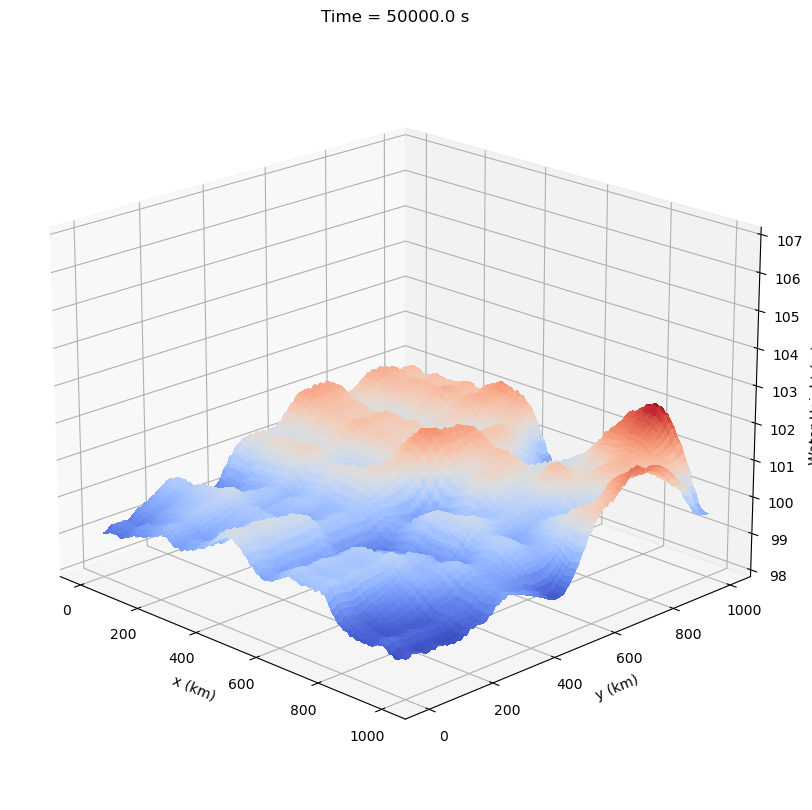

In [ ]:
# ----------------------------
# 3D Surface Plot Animation 
# ----------------------------
h_record = np.array(h_record)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X / 1e3, Y / 1e3, h_record[0], cmap='coolwarm', shade=True, linewidth=0, edgecolor='none', antialiased=False, rcount=20*ny, ccount=20*nx)
ax.set_zlim(h_bg - 2, h_bg + 7)
ax.view_init(elev=20, azim=315)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Water Height (m)')
ax.set_title("2D Shallow Water with Coriolis")

def update(frame):
    ax.clear()
    surf = ax.plot_surface(X / 1e3, Y / 1e3, h_record[frame], cmap='coolwarm', shade=True, linewidth=0, edgecolor='none', antialiased=False, rcount=20*ny, ccount=20*nx)
    ax.set_zlim(h_bg - 2, h_bg + 7)
    ax.view_init(elev=20, azim=315)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_zlabel('Water Height (m)')
    ax.set_title(f"Time = {frame * output_every * dt:.1f} s")
    return surf,

anim = FuncAnimation(fig, update, frames=len(h_record), interval=10)
anim.save("swe_animation_surface_2D.gif", writer=PillowWriter(fps=120))
plt.show()
